Random Forest MAE = 1.72 µg/m³  (baseline was 3.91 µg/m³)


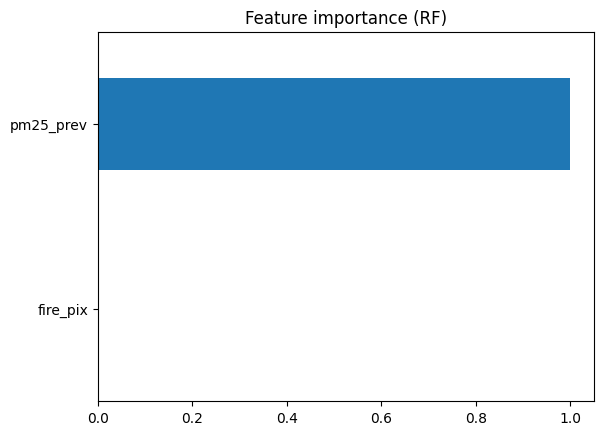

In [2]:
# ================================================================
#  Random‑Forest model: PM₂.₅ ← yesterday PM₂.₅ + today fire‑pixels
# ================================================================
import subprocess, sys, importlib, pandas as pd, numpy as np

# --- 0) make sure scikit‑learn exists (auto‑install if missing) --
try:
    import sklearn
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn", "--quiet"])
    import sklearn

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics  import mean_absolute_error
import matplotlib.pyplot as plt

# --- 1) paths ----------------------------------------------------
PM_FILE   = "../data/pm25_Reno_2024-07-01.csv"  # ← change if different
FIRE_FILE = "../data/fires_Reno_2025.csv"       # ← file you saved

# --- 2) daily PM₂.₅ mean ----------------------------------------
pm = (pd.read_csv(PM_FILE, parse_dates=["datetime_utc"])
        .set_index("datetime_utc")
        .resample("1D")["pm25"]
        .mean()
        .rename("pm25")
        .to_frame())

# --- 3) daily fire‑pixel counts ---------------------------------
fires = (pd.read_csv(FIRE_FILE, parse_dates=["acq_date"])
           .groupby("acq_date")
           .size()
           .rename("fire_pix")
           .to_frame())

# --- 4) align indexes & feature eng. -----------------------------
# Make both indexes tz‑naive and date‑only
pm.index    = pd.to_datetime(pm.index,   utc=True).tz_convert(None).normalize()
fires.index = pd.to_datetime(fires.index, utc=True).tz_convert(None).normalize()

df = (pm.join(fires, how="left")
         .fillna(0)
         .assign(pm25_prev=lambda x: x["pm25"].shift(1))
         .dropna())                            # first row has no prev‑day val

X = df[["fire_pix", "pm25_prev"]]
y = df["pm25"]

# --- 5) simple train/test split: last 30 days = test --------------
test_start = df.index.max() - pd.Timedelta(days=30)
train_mask = df.index < test_start
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

# --- 6) fit Random Forest -----------------------------------------
rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred)
print(f"Random Forest MAE = {mae_rf:.2f} µg/m³  "
      "(baseline was 3.91 µg/m³)")

# --- 7) quick feature importance plot (optional) ------------------
(pd.Series(rf.feature_importances_, index=X.columns)
   .plot.barh(title="Feature importance (RF)"));
plt.show()
